In [72]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [73]:
print(tf.__version__)

2.10.0


In [74]:
def list_image_files(directory):

    files = os.listdir(directory)
    
    # Filter out only the image files (assuming images have extensions like .jpg, .png, .jpeg)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    
    return image_files


In [75]:
# Example usage:
directories = ['HAM10000_images_part_1','HAM10000_images_part_2', 'HAM1000_Dataset']
images1 = list_image_files(directories[0])
images2 = list_image_files(directories[1])

print(os.getcwd())
print(pathlib.Path.cwd())
DATASET_PATH = pathlib.Path(directories[2])
image_count = len(list(DATASET_PATH.glob('**/*.jpg')))
print(image_count)

/Users/vn1/map/testing_images
/Users/vn1/map/testing_images
3686


In [76]:
# def turn_into_values(file_path):
#     with open(file_path, 'r') as file:
#         lines = file.readlines()

#         data = {x : [] for x in lines[0].strip().split(',')}
#         for column in data.keys():
#             index = list(data.keys()).index(column)
#             for line in lines[1:]:
#                 values = line.strip().split(',')
#                 val = values[index]
#                 data[column].append(val)
        
#         return data

def parse_txt_file(file_path):
    data_dict = {}
    with open(file_path, 'r') as file:
        headers = file.readline().strip().split(',')
        for line in file:
            values = line.strip().split(',')
            image_id = values[1]  # Assuming image_id is the second value in each row
            data_dict[image_id] = {}
            for i in range(2, len(headers)):  # Starting from index 2 since we skip image_id
                data_dict[image_id][headers[i]] = values[i]
    return data_dict



metadata_file_path = 'HAM10000_metadata'
data = parse_txt_file(metadata_file_path)

Pseudocode:

- Iterate through all the filenames
    - Check if they exist in the metadata
        - if they do exist --> get their classification, create a folder with that as the classification, and add that **image** to that folder

In [77]:
def create_folder(folder_name):
    try:
        os.mkdir(folder_name)
        #print(f"Folder '{folder_name}' created successfully.")
    except FileExistsError:
        print(f"Folder '{folder_name}' already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")



def move_image(source_folder, destination_folder, image_name):
    try:
        source_path = os.path.join(source_folder, image_name)
        destination_path = os.path.join(destination_folder, image_name)

        if os.path.exists(destination_path):
            pass
        else:
            shutil.move(source_path, destination_path)
            #print(f"Image '{image_name}' moved successfully from '{source_folder}' to '{destination_folder}'.")
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [78]:
import os


folder_path = directories[0]

# Initialize counter
counter = 0

create_folder("HAM1000_Dataset")
if(not(os.path.exists("HAM1000_Dataset"))):
# Iterate through files in the folder
    for filename in os.listdir(folder_path):
        # Check if the filename matches the image ID
        for id in list(data.keys()):
            if filename.startswith(id):
                values = data[filename[:-4]]
                exp_path = f"HAM1000_Dataset/{values['dx']}"
                if (not (os.path.exists(exp_path))):
                    create_folder(exp_path)
                    move_image(directories[0], exp_path, filename)
                move_image(directories[0], exp_path, filename)
            

Folder 'HAM1000_Dataset' already exists.


In [79]:
batch_size = 64
img_height = 450
img_width = 600

In [80]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3686 files belonging to 7 classes.
Using 2949 files for training.


In [81]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3686 files belonging to 7 classes.
Using 737 files for validation.


In [82]:
class_names = train_ds.class_names
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


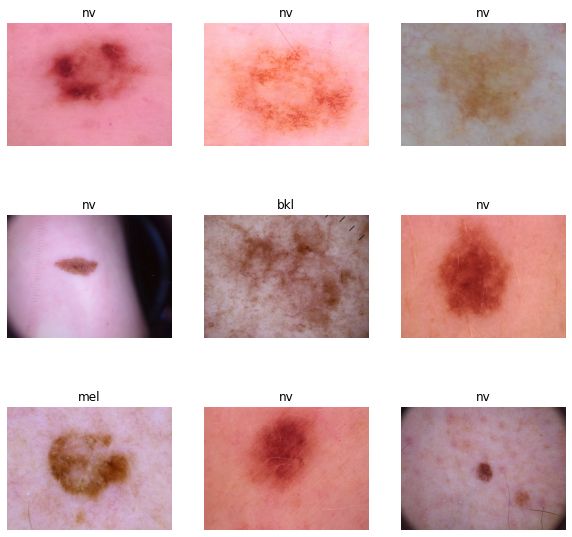

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [84]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 450, 600, 3)
(64,)


In [85]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [86]:
normalization_layer = layers.Rescaling(1./255)

In [87]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2024-04-09 23:10:48.828354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9 of 1000
2024-04-09 23:10:58.170708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 20 of 1000
2024-04-09 23:11:08.179726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31 of 1000
2024-04-09 23:11:18.245285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 45 of 1000
2024-04-09 23:11:19.241897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


0.1254902 0.89019614


In [88]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 450, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 450, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 150, 64)      1

In [92]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

47/47 [==============================] - 582s 12s/step - loss: 0.9910 - accuracy: 0.6768 - val_loss: 0.9276 - val_accuracy: 0.6920


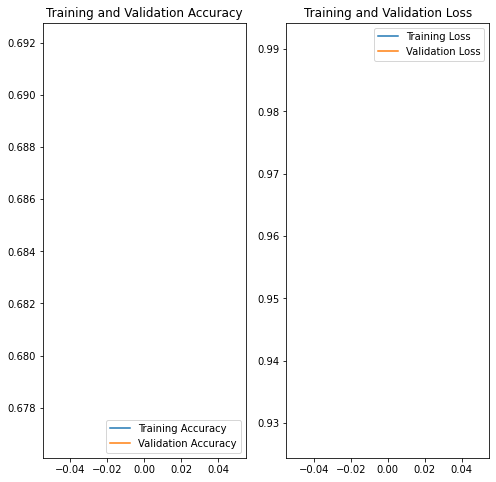

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()